In [1]:
# Import pandas for data handling
import pandas as pd

# NLTK is our Natural-Language-Took-Kit
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Libraries for helping us with strings
import string
# Regular Expression Library
import re

# Import our text vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


# Import our classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier


# Import some ML helper function
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


# Import our metrics to evaluate our model
from sklearn import metrics
from sklearn.metrics import classification_report


# Library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# You may need to download these from nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [9]:
df = pd.read_csv("data/bbc-news-data.csv", sep = '\t')
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [10]:
df.shape

(2225, 4)

In [11]:
df.isnull().sum()

category    0
filename    0
title       0
content     0
dtype: int64

In [12]:
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

# Preliminary making of models

In [13]:
#functions to clean up text
def return_lower(text):
    return text.lower()

def remove_punctuation(text):
    text = re.sub(r'[^\w\s]','', text)
    return text

def remove_stopwords(text):
    words = word_tokenize(text)
    valid_words = []
    for word in words:
        if word not in stopwords:
            valid_words.append(word)
    text = " ".join(valid_words)
    return text;

def stem_words(text):
    #initialize stemmer
    porter = PorterStemmer()
    #tokenize words
    words = word_tokenize(text)
    #place to append valid words
    valid_words = []
    
    for word in words:
        stem_word = porter.stem(word)
        valid_words.append(stem_word)
    text = " ".join(valid_words)
    return text

def text_pipeline(input_string):
    input_string = return_lower(input_string)
    input_string = remove_punctuation(input_string)
    input_string = remove_stopwords(input_string)
    input_string = stem_words(input_string)
    return input_string

In [16]:
#Try making clean titles
df['title_clean'] = df['title'].apply(text_pipeline)

print("ORIGINAL TEXT\n:", df['title'][0])
print("CLEANDED TEXT\n:", df['title_clean'][0])

ORIGINAL TEXT
: Ad sales boost Time Warner profit
CLEANDED TEXT
: ad sale boost time warner profit


In [17]:
#Set up for NLP
X = df['title_clean'].values
y = df['category'].values

In [18]:
#text vectorization Tfidf
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)
print(X.shape)
print("We have:", X.shape[-1], "features")

(2225, 3094)
We have: 3094 features


In [41]:
#Training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=102121)

params = {
    'alpha':[ 0.1, 0.2, 0.4, 1],
}

grid_search_cv = GridSearchCV(
    estimator = MultinomialNB(),
    param_grid = params,
    scoring = 'f1_weighted'
)

grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_params_)

model = grid_search_cv.best_estimator_

{'alpha': 0.2}


In [42]:
#Evaluate model
accuracy = model.score(X_test, y_test)
print("Model Accuracy: %f" % accuracy)

Model Accuracy: 0.802247


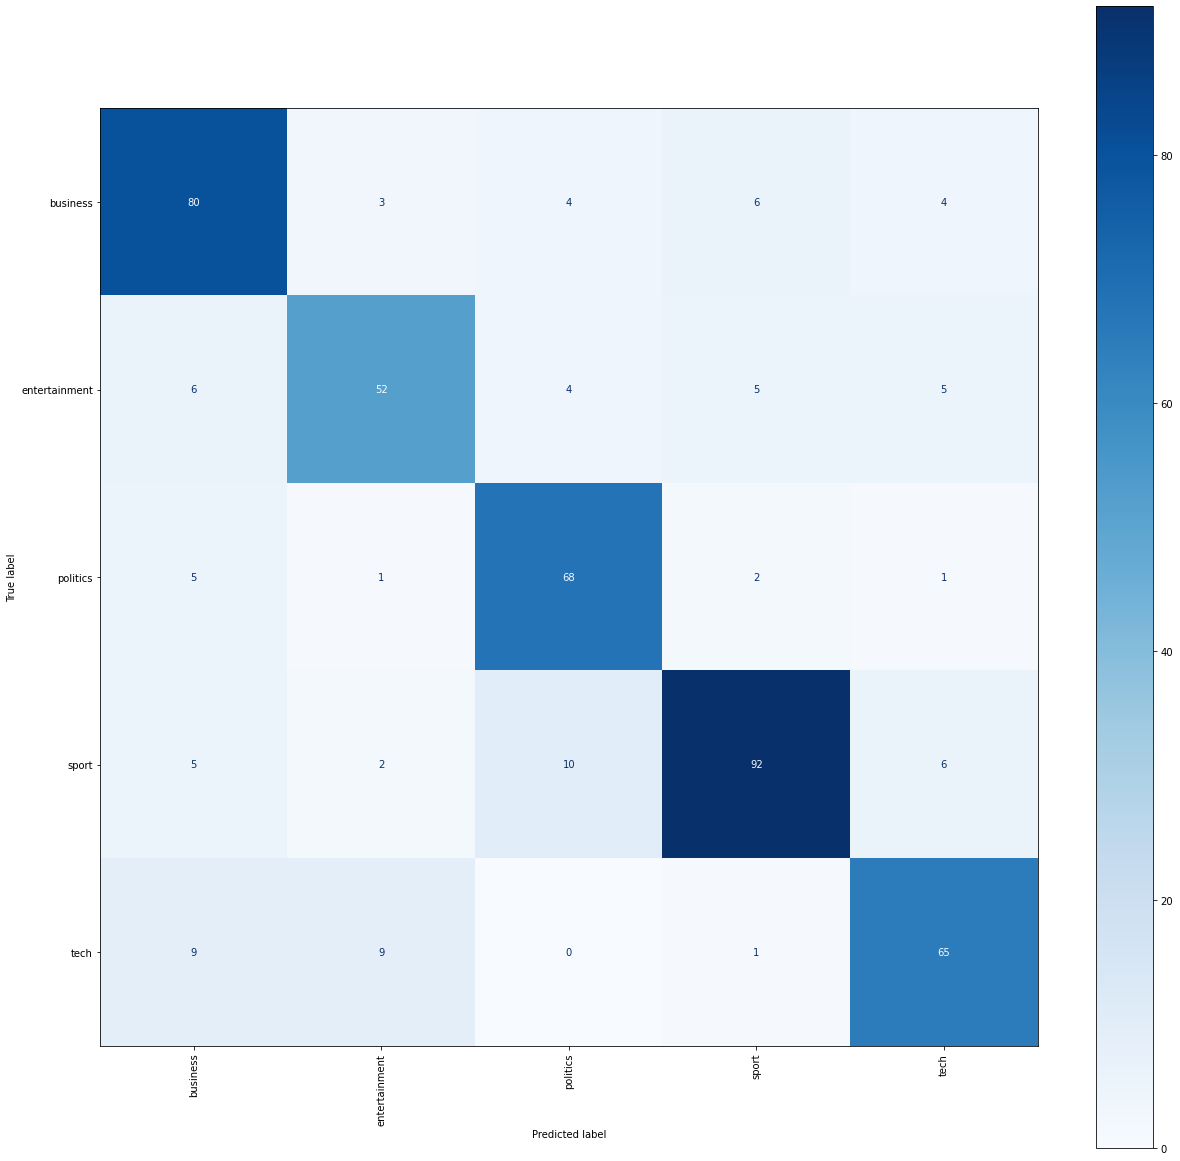

In [43]:
# Confusion matrix of our predictions
fig, ax = plt.subplots(figsize=(21, 21))

disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=model.classes_,
                             cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=90)
disp

In [44]:
#classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=model.classes_))

               precision    recall  f1-score   support

     business       0.76      0.82      0.79        97
entertainment       0.78      0.72      0.75        72
     politics       0.79      0.88      0.83        77
        sport       0.87      0.80      0.83       115
         tech       0.80      0.77      0.79        84

     accuracy                           0.80       445
    macro avg       0.80      0.80      0.80       445
 weighted avg       0.80      0.80      0.80       445



(2225, 3754)
We have: 3754 features
{'alpha': 0.1}
Model Accuracy: 0.808989


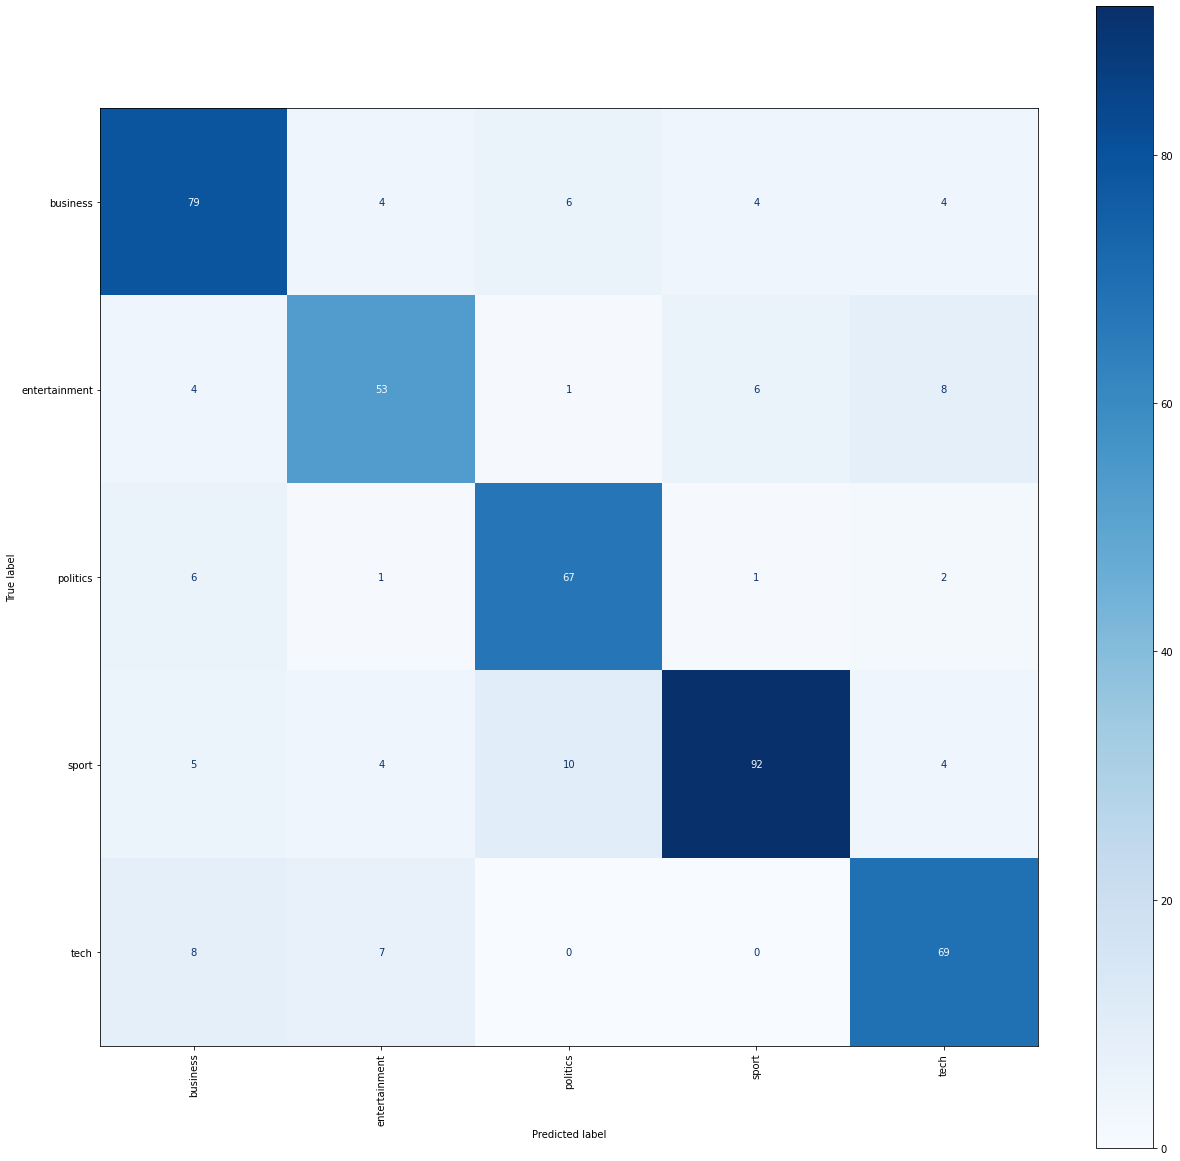

In [45]:
#With raw titles might perform better?
X = df['title'].values
y = df['category'].values

vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)
print(X.shape)
print("We have:", X.shape[-1], "features")

#Training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=102121)

params = {
    'alpha':[ 0.1, 0.2, 0.4, 1],
}

grid_search_cv = GridSearchCV(
    estimator = MultinomialNB(),
    param_grid = params,
    scoring = 'f1_weighted'
)

grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_params_)

model = grid_search_cv.best_estimator_

#Evaluate model
accuracy = model.score(X_test, y_test)
print("Model Accuracy: %f" % accuracy)

# Confusion matrix of our predictions
fig, ax = plt.subplots(figsize=(21, 21))

disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=model.classes_,
                             cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=90)
disp

In [46]:
#classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=model.classes_))

               precision    recall  f1-score   support

     business       0.77      0.81      0.79        97
entertainment       0.77      0.74      0.75        72
     politics       0.80      0.87      0.83        77
        sport       0.89      0.80      0.84       115
         tech       0.79      0.82      0.81        84

     accuracy                           0.81       445
    macro avg       0.81      0.81      0.81       445
 weighted avg       0.81      0.81      0.81       445



In [ ]:
#noted f1 score is 0.01 better!

(2225, 3094)
We have: 3094 features
{'alpha': 0.4}
Model Accuracy: 0.808989
               precision    recall  f1-score   support

     business       0.77      0.81      0.79        97
entertainment       0.82      0.74      0.77        72
     politics       0.78      0.90      0.83        77
        sport       0.89      0.78      0.83       115
         tech       0.78      0.82      0.80        84

     accuracy                           0.81       445
    macro avg       0.81      0.81      0.81       445
 weighted avg       0.81      0.81      0.81       445



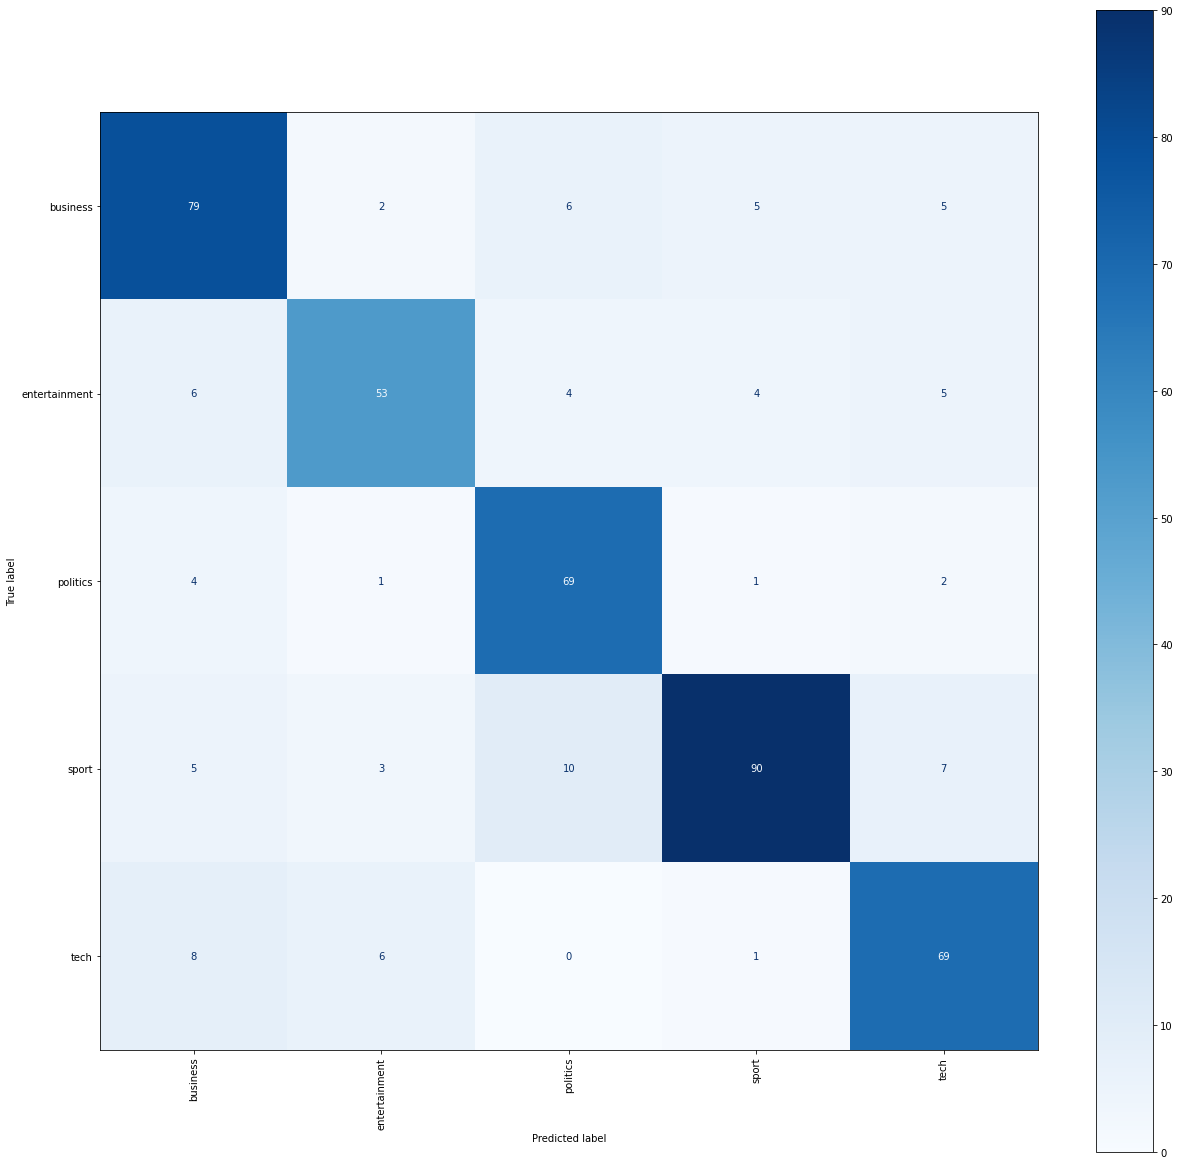

In [53]:
#Vectorizer to BOW might also be better?
X = df['title_clean'].values
y = df['category'].values

vectorizer = CountVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)
print(X.shape)
print("We have:", X.shape[-1], "features")

#Training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=102121)

params = {
    'alpha':[ 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
}

grid_search_cv = GridSearchCV(
    estimator = MultinomialNB(),
    param_grid = params,
    scoring = 'accuracy'
)

grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_params_)

model = grid_search_cv.best_estimator_

#Evaluate model
accuracy = model.score(X_test, y_test)
print("Model Accuracy: %f" % accuracy)

#classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=model.classes_))

# Confusion matrix of our predictions
fig, ax = plt.subplots(figsize=(21, 21))

disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=model.classes_,
                             cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=90)
disp